In [26]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score, 
                             recall_score, confusion_matrix, plot_confusion_matrix, 
                             make_scorer,multilabel_confusion_matrix,ConfusionMatrixDisplay)

from sklearn import tree

from xgboost import XGBClassifier

import warnings

from CF_5_Modelling import (add_model_score, feat_imp, scorer_pos_neg_class,
                            scorer_confusion_matrix)

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

rng = 1379543626 #int(np.random.default_rng().random()*(2**32))

%matplotlib inline
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data_weekly_class.csv')
df_full = pd.read_csv(data_processed_dir+'processed_weekly_class_full.csv')
df_full.date = pd.to_datetime(df_full.date)
df_full = df_full.sort_values(by='date',ascending=True).reset_index(drop=True)
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot_lag_15,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons,rig_change_4bin_week+4,rig_change_4bin_week+8,rig_pct_change_week+4,rig_pct_change_week+8
0,2011-02-04,818.0,82.030,86.752,89.520,100.358,90.678,93.31,95.278,96.458,...,86.752,47.663605,86.752,42.542887,86.752,90.206492,--,++,-0.020782,0.072127
1,2011-02-11,805.0,84.928,88.496,85.514,99.904,86.688,90.01,92.948,94.708,...,88.496,47.480506,88.496,42.376184,88.496,89.856690,++,++,0.027329,0.100621


In [4]:
num_col_rig_change = df.columns.str.contains('rig_').sum()
df = df.drop(['brent_spot','wti_fut_1','wti_fut_2','wti_fut_3','wti_fut_4','wti_spot_lag_15','wti_spot_lag_9',
              'usa_l48_prod','usa_stocks_all','usa_net_import',
              'world_cons','world_cons_smooth','oecd_cons','non-oecd_cons','non-oecd_cons_smooth',],axis=1)
df.shape

(502, 15)

## Train Test Split
Define features X, and target variable y

In [5]:
X = pd.concat([df.iloc[:,1:-num_col_rig_change],df[df.columns[df.columns.str.contains('rig_pct')]]],axis=1)
y = df.loc[:,'rig_change_4bin_week+8']

old_class = ['--','-','+','++']
new_class = [int(0),int(1),int(2),int(3)]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=rng)

pct_change_train = X_train[X_train.columns[X_train.columns.str.contains('rig_pct')]]
pct_change_test = X_test[X_train.columns[X_train.columns.str.contains('rig_pct')]]

X_train = X_train[X_train.columns[~X_train.columns.str.contains('rig_pct')]]

X_test = X_test[X_train.columns[~X_train.columns.str.contains('rig_pct')]]

X = df.iloc[:,2:-num_col_rig_change]

model_score = pd.DataFrame(columns=['accuracy','balanced accuracy','precision avg','recall avg','precision (++)','precision (+)','precision (-)','precision (--)','recall (++)','recall (+)','recall (-)','recall (--)','pos neg class','max depth'])

In [6]:
from joblib import dump, load

model = load('best_model.joblib')

y_pred = model.predict(X_test)

add_model_score(model_score,model,'XGB_neg_pos_import',y_test,y_pred)

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
XGB_neg_pos_import,0.825301,0.819532,0.826535,0.825301,0.853659,0.77193,0.821429,0.875,0.813953,0.846154,0.69697,0.921053,0.957831,8


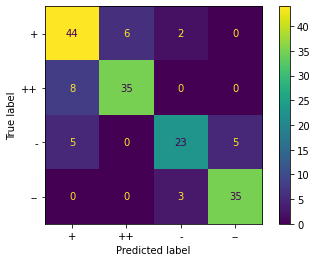

In [7]:
plot_confusion_matrix(model,X_test,y_test)

# Review of model mis-classifications

In [8]:
y_comb = pd.concat([y_test,pd.Series(y_pred,index=y_test.index),pct_change_test['rig_pct_change_week+8']],ignore_index=True,axis=1)
y_comb.columns = ['test','pred','pct_change']

df_quantiles = pd.DataFrame(pd.read_csv(data_processed_dir+'quantiles.csv',index_col=0).loc['week+8',:])

def misclass_check(y_comb,test_val,pred_val):
    misclass = y_comb[(y_comb.test == test_val) & (y_comb.pred == pred_val)]
    
    inc_index = y_comb[(y_comb.test == test_val) & (y_comb.pred == pred_val)].sort_index().index.to_list()
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df_full.date,df_full['Total US RigCount'],c='b',alpha=0.5,label='Rig Count Data')
    ax.scatter(df_full.date[inc_index],df_full['Total US RigCount'][inc_index],c='r',alpha=1,s=10,label='data')
    ax.scatter(df_full.date[[x+8 for x in inc_index]],df_full['Total US RigCount'][[x+8 for x in inc_index]],c='g',alpha=1,s=10,label='predicted')

    ax.legend()
    
    plt.show()
    
    return misclass

df_quantiles

,week+8
25%,-0.033334
50%,0.009174
75%,0.054922


## Positive / Negative Misclassifications 

#### True '-', Predicted '+'

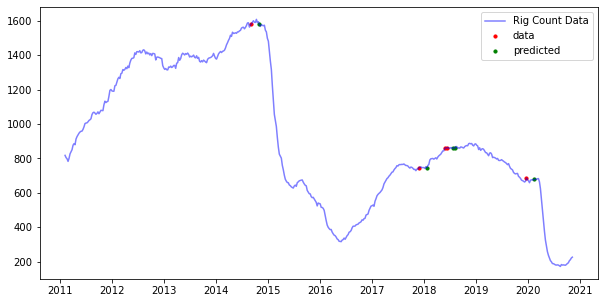

,test,pred,pct_change
381,-,+,-0.001164
383,-,+,-0.003480
463,-,+,-0.010219
355,-,+,0.000000
187,-,+,-0.001263


In [9]:
misclass_check(y_comb,'-','+')

Index 355 has no change. Indeces 187, 381, 383 are less than a percent decrease. This misclassifications is very close to the border of the class bins. 

## Misclassifications within positive / negative classes

#### True '++', Predicted '+'

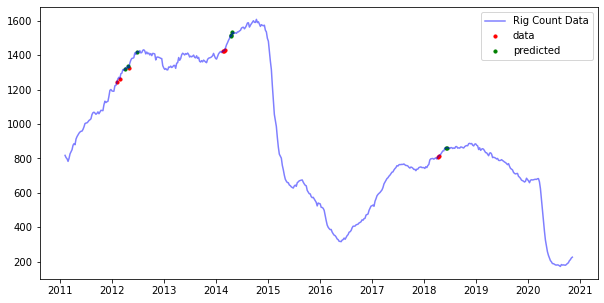

,test,pred,pct_change
158,++,+,0.066058
64,++,+,0.070030
159,++,+,0.059649
160,++,+,0.072727
55,++,+,0.056917
375,++,+,0.057669
374,++,+,0.065594
52,++,+,0.058635


In [10]:
misclass_check(y_comb,'++','+')

Cut off for the '+', '++' bins is 5.49%. Both of these are very close to the cutoff.

#### True '+', Predicted '++'

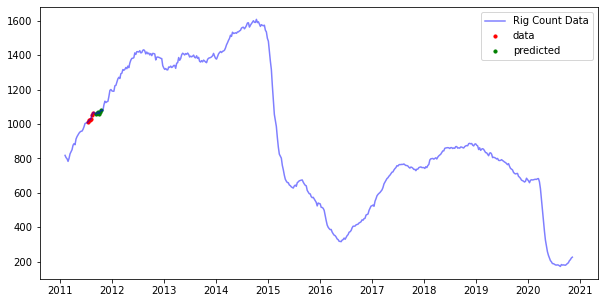

,test,pred,pct_change
23,+,++,0.043435
25,+,++,0.044878
26,+,++,0.028128
27,+,++,0.014218
28,+,++,0.013133
24,+,++,0.040157


In [11]:
misclass_check(y_comb,'+','++')

No misclassifications between True : '+' and Predicted : '++'

#### True '--', Predicted '-'

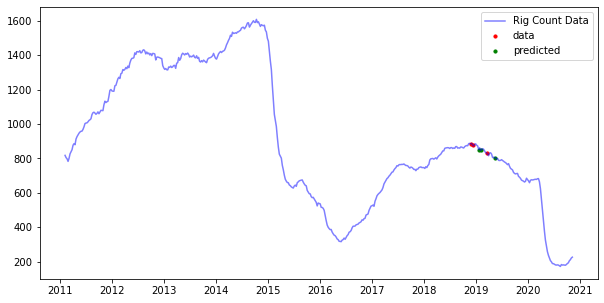

,test,pred,pct_change
423,--,-,-0.033613
409,--,-,-0.034208
407,--,-,-0.037288


In [12]:
misclass_check(y_comb,'--','-')

These misclassifications are very close to cut off. The cut off between '-' and '--' is 3.3%.

#### True '-', Predicted '--'

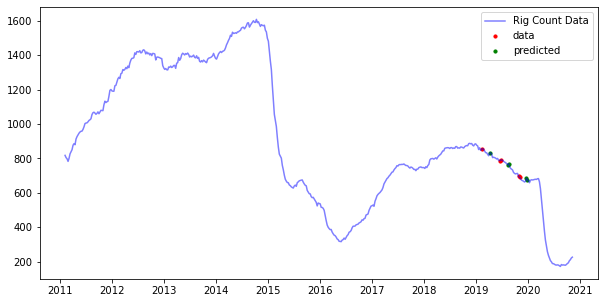

,test,pred,pct_change
418,-,--,-0.026932
437,-,--,-0.024081
436,-,--,-0.030457
455,-,--,-0.015805
456,-,--,-0.020260


In [13]:
misclass_check(y_comb,'-','--')

Looks like this is the most difficult classification, no consistent misclassification here.

Overall - the data shows very good performance over the course of the dataset with no errors in 2020. The period is not significantly under tested (30% of test values are within 2020, as per the train / test split).

In [14]:
X_train[X_train.index >= df.date[(df.date > '2020')].index.min()].shape[0] #26
X_test[X_test.index >= df.date[(df.date > '2020')].index.min()].shape[0] #11

11

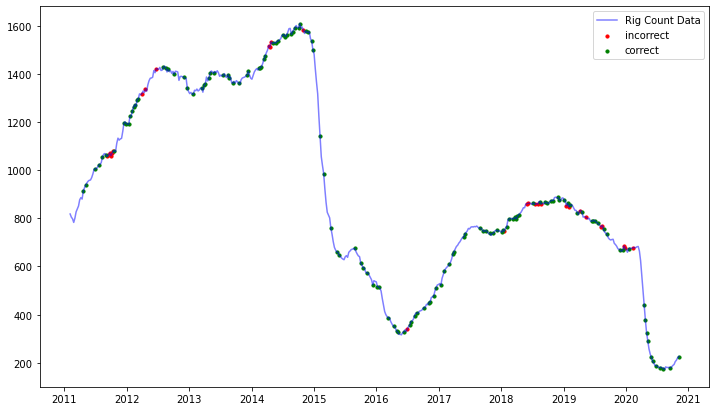

In [20]:
misclass_index = y_comb[(y_comb.test != y_comb.pred)].index.to_list()
class_index = y_comb[(y_comb.test == y_comb.pred)].index.to_list()

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(df_full.date,df_full['Total US RigCount'],c='b',alpha=0.5,label='Rig Count Data')
ax.scatter(df_full.date[[x+8 for x in misclass_index]],df_full['Total US RigCount'][[x+8 for x in misclass_index]],c='r',alpha=1,s=10,label='incorrect')
ax.scatter(df_full.date[[x+8 for x in class_index]],df_full['Total US RigCount'][[x+8 for x in class_index]],c='g',alpha=1,s=10,label='correct')

ax.legend()
    
plt.show()

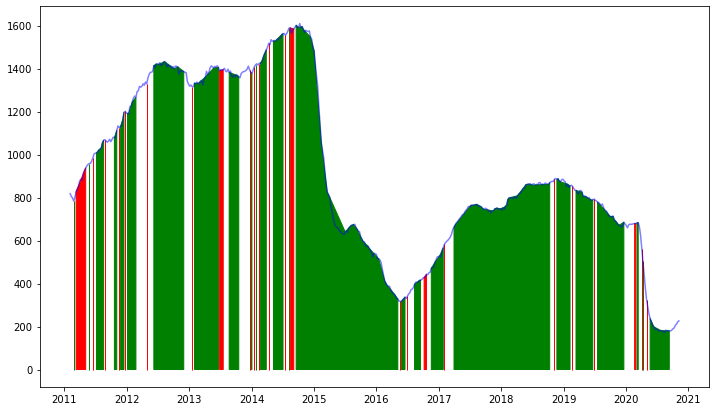

In [69]:
misclass_index = y_comb[(y_comb.test != y_comb.pred)].index.to_list()
class_index = y_comb[(y_comb.test == y_comb.pred)].index.to_list()

fig, ax = plt.subplots(figsize=(12,7))
ax.plot(df_full.date,df_full['Total US RigCount'],c='b',alpha=0.5,label='Rig Count Data')
ax.fill_between(df_full.date[y_comb.index].sort_index(),pd.Series([0]*510,index=np.arange(len(df_full.date)))[y_comb.index].sort_index(),df_full['Total US RigCount'][y_comb.index].sort_index(), where=y_comb.test == y_comb.pred,color='g')
ax.fill_between(df_full.date[y_comb.index].sort_index(),pd.Series([0]*510,index=np.arange(len(df_full.date)))[y_comb.index].sort_index(),df_full['Total US RigCount'][y_comb.index].sort_index(), where=y_comb.test != y_comb.pred,color='r')